### 作業
理解範例後請嘗試將關鍵點畫在圖像上，確保圖像及資料有正確讀取。
Hint: 可以用 [matplotlib 的 scatter](https://matplotlib.org/3.1.1/gallery/shapes_and_collections/scatter.html) 或者 [opencv 的 cv2.circle](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html)

### 範例
接下來的程式碼會示範如何讀取 kaggle facial keypoint detection 資料集

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
path = "/content/gdrive/My Drive/Colab Notebooks/Top4_CNN"
import os
os.chdir(path)
os.chdir("cupoy_cv_part4")
!ls   #確認path已經到local目錄

best_weights.h5  model_with_augment.h5	training.csv  weights_with_augment.h5
model.h5	 test.csv		weights.h5


In [0]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
# os.environ['KAGGLE_USERNAME'] = '____' # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
# os.environ['KAGGLE_KEY'] = '____' # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
# !kaggle competitions download -c facial-keypoints-detection
# !unzip test.zip
# !unzip training.zip

### 資料前處理
資料分為兩部分，一個是關鍵點坐標，總共 15 個關鍵點，所以坐標相關的值有 15 x 2 = 30 維；
另外還有 96 x 96 的灰階像素值。

讀取資料後，先簡單地過濾有缺失某些關鍵點坐標的資料，然後再把資料 scale 到 [-0.5, 0.5] 的範圍

In [0]:
# 讀取 csv 文件
data = pd.read_csv("training.csv")

In [6]:
# 前 5 筆資料, .T 的作用是轉置，如果不理解可以和 data.head() 的結果相比較
data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [7]:
data['Image'][0]

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

用 pandas 讀取 csv 文件後可以發現前 30 個 column 是坐標值，最後一個 column 是圖片像素值的字串 (以空白鍵區隔)，接下來我們就以下的函數來做資料的讀取以及前處理，請盡量仔細理解這個函數

In [0]:
# 過濾有缺失值的 row
data = data.dropna()

# 將圖片像素值讀取為 numpy array 的形態
data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

# 單獨把圖像 array 抽取出來
imgs = np.vstack(data['Image'].values)/255
# reshape 為 96 x 96
imgs = imgs.reshape(data.shape[0], 96, 96)
# 轉換為 float
imgs = imgs.astype(np.float32)

# 提取坐標的部分
points = data[data.columns[:-1]].values

# 轉換為 float
points = points.astype(np.float32)

# normalize 坐標值到 [-0.5, 0.5]
points = points/96 - 0.5

In [9]:
print("圖像資料:", imgs.shape, "\n關鍵點資料:", points.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [0]:
sample_img = imgs[0]
sample_points = points[0]

In [0]:
pt_x = np.array([])
pt_y = np.array([])
nubr = int(sample_points.shape[0]/2)
for i in range(nubr):
  pt_x = np.hstack((pt_x,sample_points[2*i]*96 + 48))
  pt_y = np.hstack((pt_y,sample_points[2*i+1]*96 + 48))

In [12]:
pt_x

array([66.0335598 , 30.22700787, 59.58207893, 73.13035011, 36.35657215,
       23.45286942, 56.95326233, 80.22712898, 40.22760773, 16.35637665,
       44.42057133, 61.19530678, 28.61449528, 43.312603  , 43.13070774])

In [13]:
pt_y

array([39.00227451, 36.42167759, 39.64742374, 39.96999836, 37.38940144,
       37.38940144, 29.03364658, 32.22813892, 29.00232124, 29.64747047,
       57.06680489, 79.97016907, 77.38899422, 72.93545723, 84.48577309])

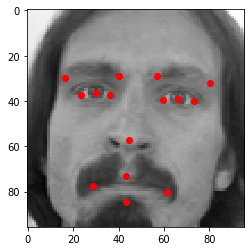

In [14]:
plt.imshow(sample_img, cmap='gray')
plt.scatter(pt_x,pt_y, color='red')